# Data
A dataset of arthropod images was obtained from Kaggle (Geir Drange, 2020). This dataset (manually compiled from iNaturalist and similar sources), contains 15376 files of 7 taxa (orders) of arthropods:
* Araneae (spiders)
* Coleoptera (beetles)
* Diptera (flies)
* Hemiptera (cicadas, aphids, ...)
* Hymenoptera (wasps, bees, ...)
* Lepidoptera (butterflies, moths)
* Odonata (dragonflies, ...)
Most images are taken in the wild, using a variety of foto equipment by multiple authors. Most images contain one specimen of interest, but some contain multiple specimens of the same or of different taxa.

This dataset is licensed as CC BY-NC-SA 4.0.

In [1]:
DATA_PATH = 'data'  # for local notebook
# DATA_PATH = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/'  # for kaggle notebook

## Reformat the images

* Resize the image, to save memory and processing time.
* Transform the images into numpy arrays.
* Keep only the red channel, to save memory and processing time. Assuming pictures of insects on green leaves are most contrasted in the red channel.
* Test the function by plotting the first image.

In [2]:
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageDraw
import numpy as np
import json

In [3]:
def format_image(path, box=None):
    """Takes a path to an image as input. Loads and rescales the image.
    Returns a numpy array representing the the image."""
    size = (64, 64)
    # Load the image using PIL
    pillow_img = Image.open(path)
    # get image crop
    if box:
        #draw = ImageDraw.Draw(pillow_img)
        xy = (box['left'], box['top'], box['left']+box['width'], box['top']+box['height'])
        #draw.rectangle(xy, outline="white", fill=None, width = 3)
        pillow_img = pillow_img.crop(xy)
    pillow_img = pillow_img.resize(size)
    img = np.array(pillow_img)
    # return(img[:,:,1] ) # 0: red, 1: green, 2: blue channel
    return(img)

In [4]:
def open_annotations(annotation_path, taxon):
    """
    Opens an annotations file.
    Returns the name of the image and the first bounding box with the correct taxon.
    """
    try:
        with open(annotation_path) as json_file:
            text = json_file.read(-1)
            data = json.loads(text)
        image_name = data['asset']['name']
        for region in data['regions']:
            if taxon in region['tags']:
                box = region['boundingBox']
                break
        return image_name, box
    except:
        return None, None

Try out the function on a test image

shape: (64, 64, 3)
min: 10 max: 255
dtype: uint8


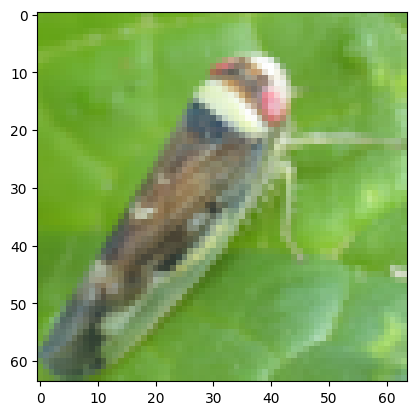

In [5]:
# Test the function on an example image 
#path = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr/Araneae/003eb3db1665.jpg"
#path = join(DATA_PATH, 'ArTaxOr/Araneae/003eb3db1665.jpg')
#taxon = 'Araneae'
#annotation_path = join(DATA_PATH, 'ArTaxOr/Araneae/annotations/ffe42f62826da1504c550ceca4ed4ae6-asset.json')
taxon = 'Hemiptera'
annotation_path = join(DATA_PATH, 'ArTaxOr/Hemiptera/annotations/bcc2d7481abaf11bd353d3f0d5f0451e-asset.json')
image_name, box = open_annotations(annotation_path, taxon)
image_path = join(DATA_PATH, 'ArTaxOr', taxon, image_name)

img = format_image(image_path, box)
print('shape:', img.shape)
print('min:', img.min(), 'max:', img.max()) # min: 0 max: 255
print('dtype:', img.dtype) # uint8

%matplotlib inline
import matplotlib.pyplot as plt

# Plot the cropped image
plt.imshow(img) 
plt.show()

## Create feature matrix

* Create a matrix of features (image pixels) vs. labels (taxa)
* Split the data into train, validation and test datasets

In [6]:

def make_matrix_from_dir(path):
    """Takes a dir as argument and returns two numpy arrays: features and labels"""
    # the feature matrix and labels list
    features = []  # the pixel data
    labels = []  # the image labels (species)

    # get a list of all images in the dataset
    taxa_in_dataset = [taxon for taxon in listdir(path) if not isfile(join(path, taxon))]
    for taxon in taxa_in_dataset:
        print(f"Processing taxon {taxon}")
        taxon_path = join(path, taxon)
        # list all annotations files
        annotations_path = join(taxon_path, 'annotations')
        annotation_file_paths = [join(annotations_path, f) for f in listdir(annotations_path) if isfile(join(annotations_path, f))]
        # load the annotation files
        for annotation_path in annotation_file_paths:
            # open annotation, get image and bounding box
            image_name, box = open_annotations(annotation_path, taxon)
            if image_name:
                # load image, convert to numpy array with 3 channels: RGB
                # resize and flatten the image to a 1-dimensional array,
                image_path = join(DATA_PATH, 'ArTaxOr', taxon, image_name)
                flat_img = format_image(image_path).flatten()
                features.append(flat_img)
                labels.append(taxon)
    # format the features array to a vector of dimensions (num_images, num_pixels_in_each_image)
    X = np.array(features)
    # convert features to floats (as expected by scikit-learn)
    X = X.astype(float)
    # pack labels in numpy array
    y = np.array(labels)
    return X, y

In [7]:
%%time
from sklearn.model_selection import train_test_split

images_path = join(DATA_PATH, 'ArTaxOr')

# Create a matrix of features (image pixels) vs. labels (taxa)
X, y = make_matrix_from_dir(images_path)

Processing taxon Hemiptera
Processing taxon Diptera
Processing taxon Hymenoptera
Processing taxon Lepidoptera
Processing taxon Coleoptera
Processing taxon Odonata
Processing taxon Araneae
CPU times: user 7min 24s, sys: 27.8 s, total: 7min 52s
Wall time: 8min 9s


Save the processed data for later use

In [9]:
np.savez_compressed(join(DATA_PATH, 'processed_data.npz'), X=X, y=y)

## References

Geir Drange (2020). Arthropod Taxonomy Orders Object Detection Dataset [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/1240192

Pedregosa et al. (2011), Scikit-learn: Machine Learning in Python, JMLR 12, pp. 2825-2830.